# Plotting ANN sampling data for alanine dipeptide

Here we plot and compare the various free energy surfaces obtained for alanine dipeptide in water using ANN sampling with different architectures and sampling parameters to show how the method is robust to user choice, and is also rapidly convergent.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.family"] = "serif"
%matplotlib inline

## Reference FEL 
This FEL was obtained from a 100ns run using ANN sampling with an (10,6) architecture, 10ps sampling interval and (60,60) grid. 

In [2]:
dt = 0.002 # Timestep in fs. 
times = np.array([100, 500, 1000, 2500, 5000, 10000, 50000, 100000]) # Times at which to plot FES (ps).
v = np.arange(-80, 5, 5) # Contours to plot.
sweep = 5000 # Sweep interval (in steps)

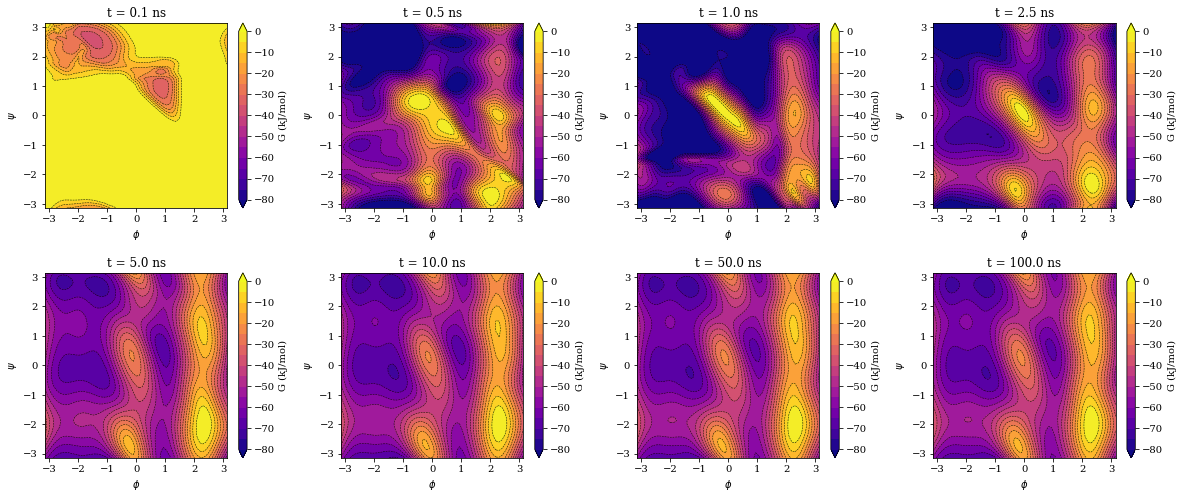

In [7]:
fig = plt.figure(figsize=(20, 8.0))
i = 1
for t in times:
    frame = int(t/(sweep*dt))
    
    X = np.loadtxt("reference/ann.dat{}".format(frame))
    xg = np.reshape(X[:,0], (61, 61))
    yg = np.reshape(X[:,1], (61, 61))
    zg = np.reshape(-X[:,3], (61, 61))
    zg = zg - np.max(zg)
    
    # Plot data.
    ax = fig.add_subplot(2, 4, i)
    fig.subplots_adjust(wspace=0.3, hspace=0.35)
    
    plt.title("t = {} ns".format(t/1000.))
    plt.contour(xg, yg, zg, v, linewidths=0.5, colors="k")
    plt.contourf(xg, yg, zg, v, cmap=plt.cm.plasma, extend="both")
    cb = plt.colorbar()
    cb.set_label("G (kJ/mol)")
    plt.xlabel("$\phi$")
    plt.ylabel("$\psi$")
    plt.xticks(np.arange(-3,4,1))
    plt.xlim((-np.pi, np.pi))
    plt.ylim((-np.pi, np.pi))    
    ax.axis("equal")
    ax.axis("tight")

    i += 1

plt.savefig("ann_reference.eps")
plt.show()

## Evaluating the network 
Here is an example, using Keras, of how one can load up the neural network FES, and evaluate it on a finer grid. We do it here for a single example. We will also use the network to compute RMSDs against other network architectures.

In [16]:
from keras.models import Sequential 
from keras.layers import Dense, Activation

# Import and define Keras network.
params = [] 
xshift = []
xscale = []
yshift = []
yscale = []
net = Sequential()
with open("reference/netstate.dat", "r") as f: 
    # Topology. 
    layers = int(f.readline())
    arch = [int(x) for x in f.readline().split()]
    
    # Scaling and shifting. 
    xscale = [float(x) for x in f.readline().split()]
    xshift = [float(x) for x in f.readline().split()]
    yscale = [float(x) for x in f.readline().split()]
    yshift = [float(x) for x in f.readline().split()]
    
    # Weights and biases.    
    for i in range(1, layers):
        b = []
        for j in range(arch[i]):
            b.append(float(f.readline()))
        b = np.array(b) 
        
        w = []
        for j in range(arch[i]*arch[i-1]):
            w.append(float(f.readline()))
        w = np.array(w).reshape(arch[i-1], arch[i])
        
        params.append(w)
        params.append(b)
        
        if i==1:
            net.add(Dense(arch[i], activation="tanh", input_dim=arch[i-1]))
        elif i==layers-1:
            net.add(Dense(arch[i], activation="linear"))
        else:
            net.add(Dense(arch[i], activation="tanh"))

net.set_weights(params)

In [17]:
# Define new high-resolution grid. 
x = np.linspace(-np.pi, np.pi, 500, endpoint=True)
y = np.linspace(-np.pi, np.pi, 500, endpoint=True)
xg, yg = np.meshgrid(x, y)

# Scale data. 
xs = np.vstack((xg.flatten(), yg.flatten())).T
xs = (xs - xshift)*xscale

# Evaluate network. Unscale data.
ys = net.predict(xs)
ys = ys/yscale + yshift
zg = -ys.reshape(500, 500)

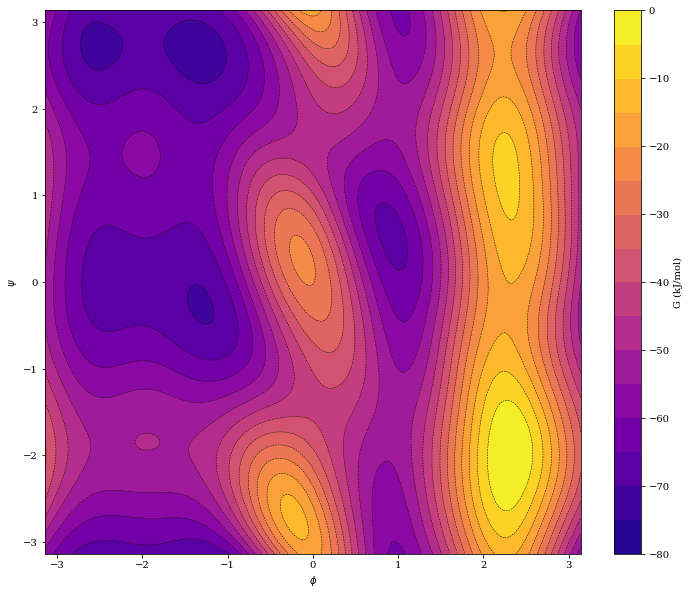

In [18]:
# Plot data.
plt.figure(figsize=(12,10))
zg = zg - np.max(zg)
plt.contour(xg, yg, zg, v, linewidths=0.5, colors="k")
plt.contourf(xg, yg, zg, v, cmap=plt.cm.plasma)
cb = plt.colorbar()
cb.set_label("G (kJ/mol)")
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")

In [19]:
def compute_rmse(xg, yg, zg):
    # Scale data. 
    xs = np.vstack((xg.flatten(), yg.flatten())).T
    xs = (xs - xshift)*xscale

    # Evaluate network. Unscale data.
    ys = net.predict(xs)
    ys = ys/yscale + yshift
    fg = -ys.reshape(zg.shape)
    fg -= np.max(fg)
    
    return np.sqrt(np.sum((fg-zg)**2)/fg.size)

## Plot FELs for different network architectures and sweep intervals

Define the different folders containing data and the corresponding network architecture and sweep intervals.

In [20]:
# Folder name, network hidden layers, sweep length. 
data = [
    ("5000_8_4", [8, 4], 5000),
    ("10000_8_4", [8, 4], 10000),
    ("5000_10_6", [10, 6], 5000),
    ("10000_10_6", [10, 6], 10000),
    ("2500_10_6", [10, 6], 2500),
    ("5000_12_18", [12, 8], 5000)
]

Loop through data, and generate contour plots and different time intervals for comparison

In [21]:
dt = 0.002 # Timestep in fs. 
times = np.array([100, 500, 1000, 2500, 5000, 10000]) # Times at which to plot FES (ps).

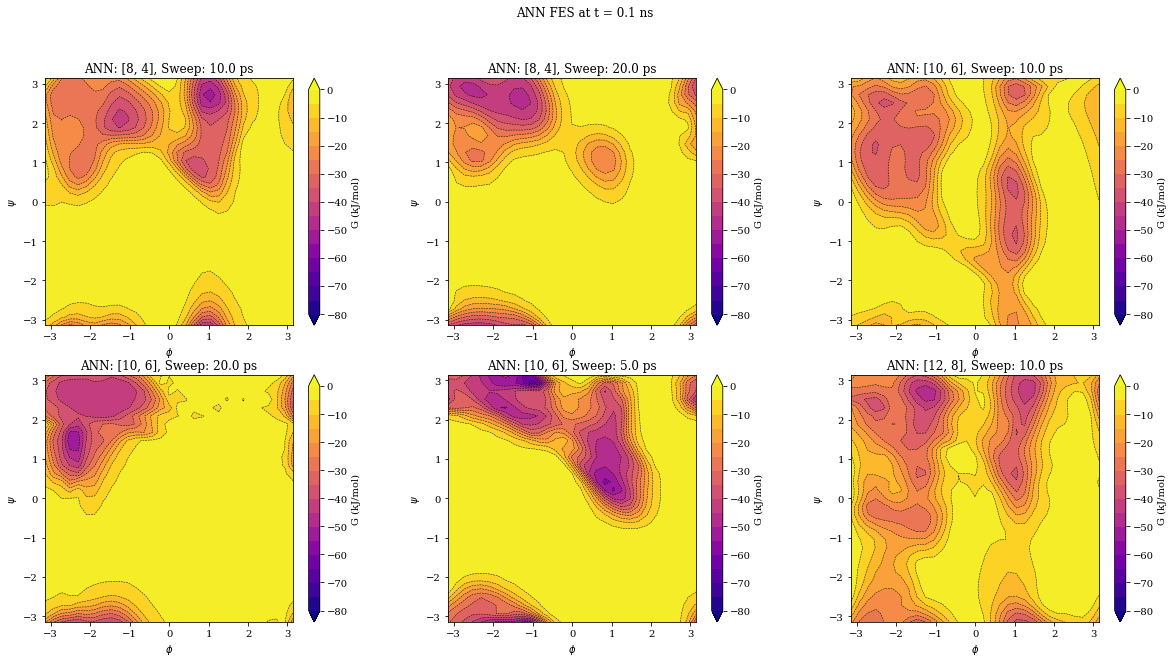

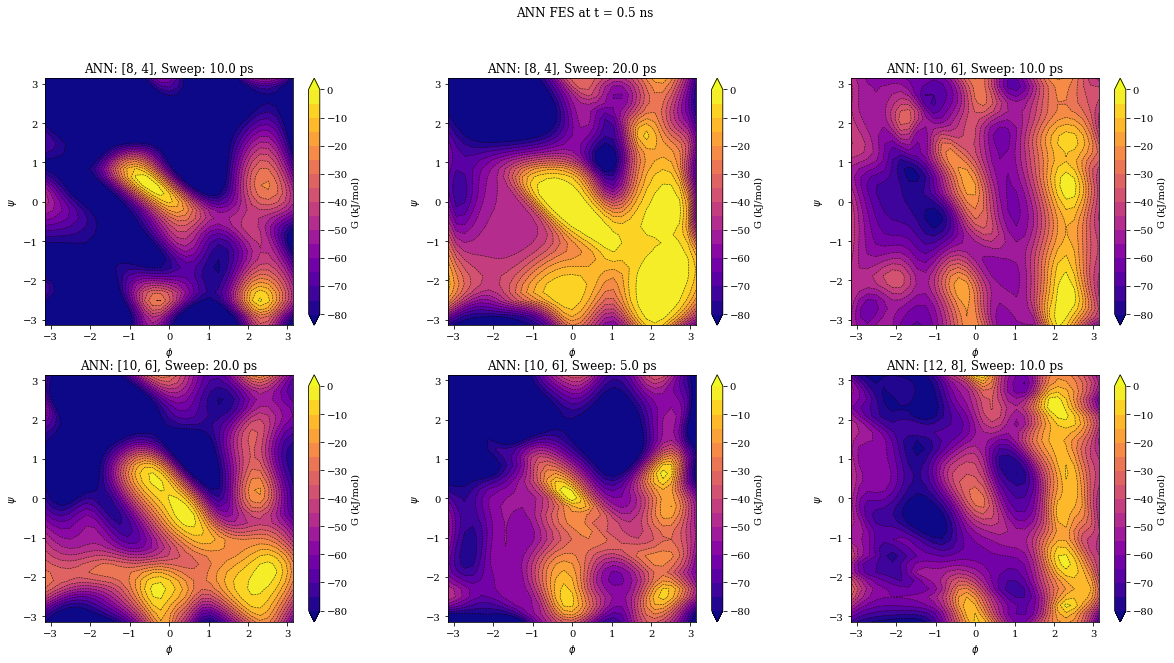

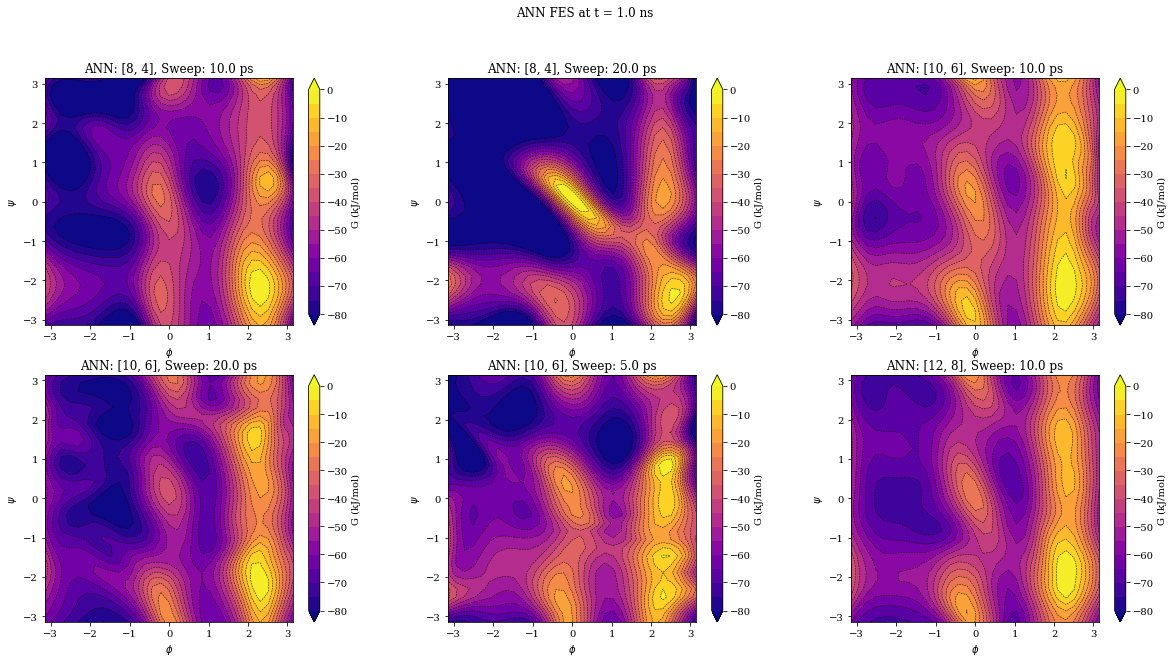

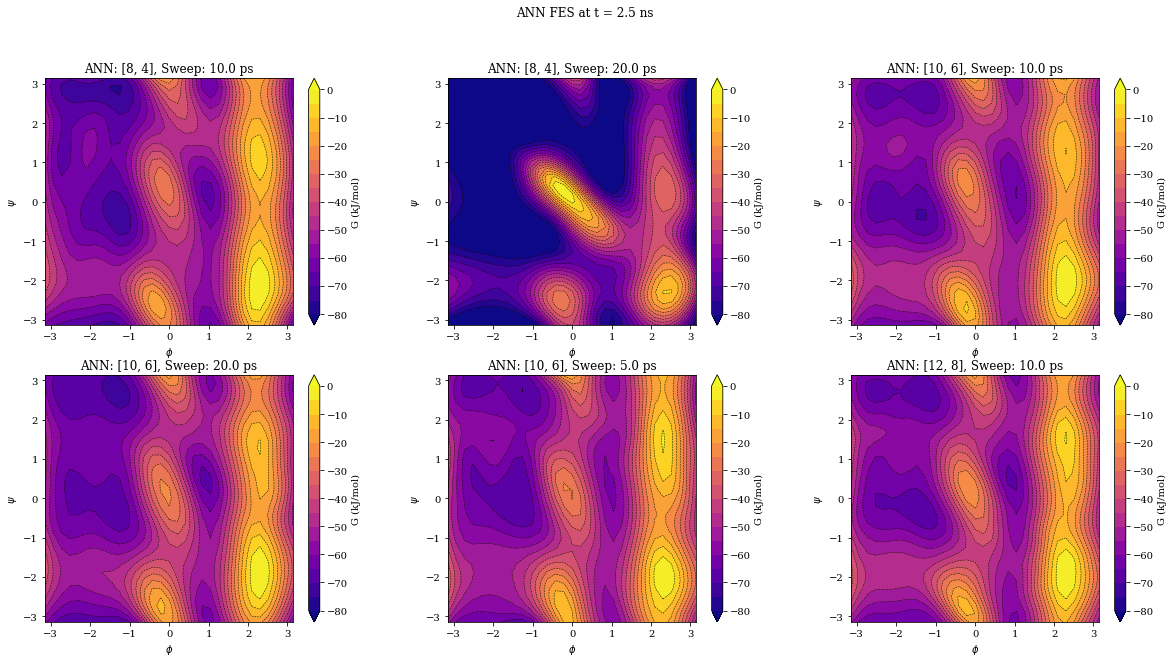

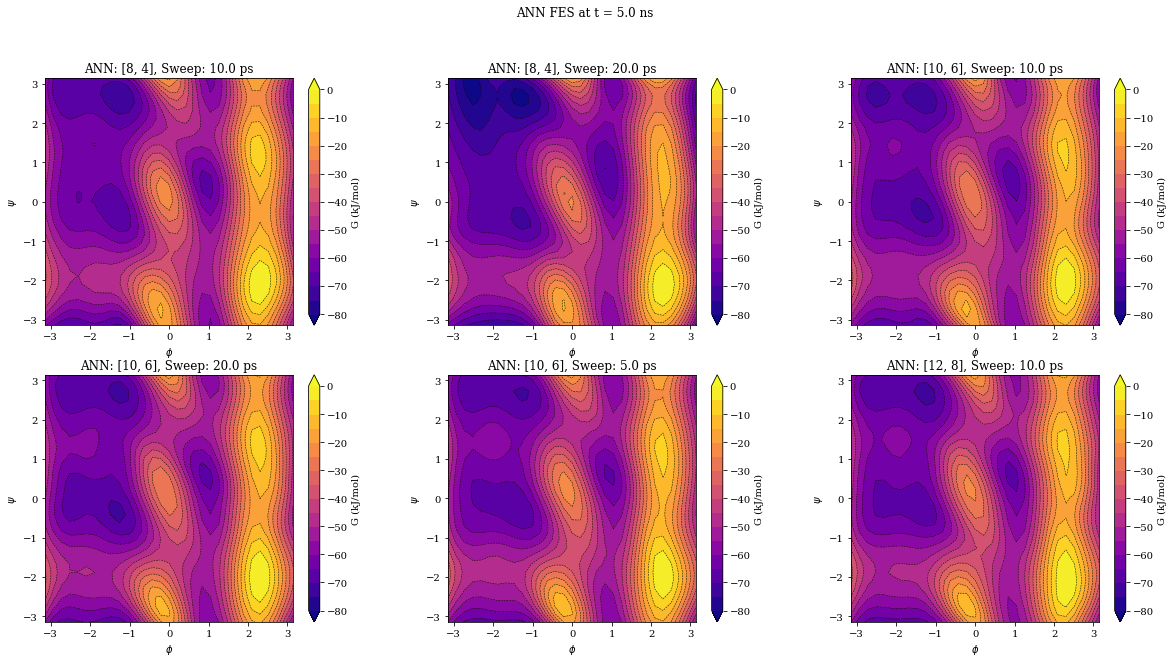

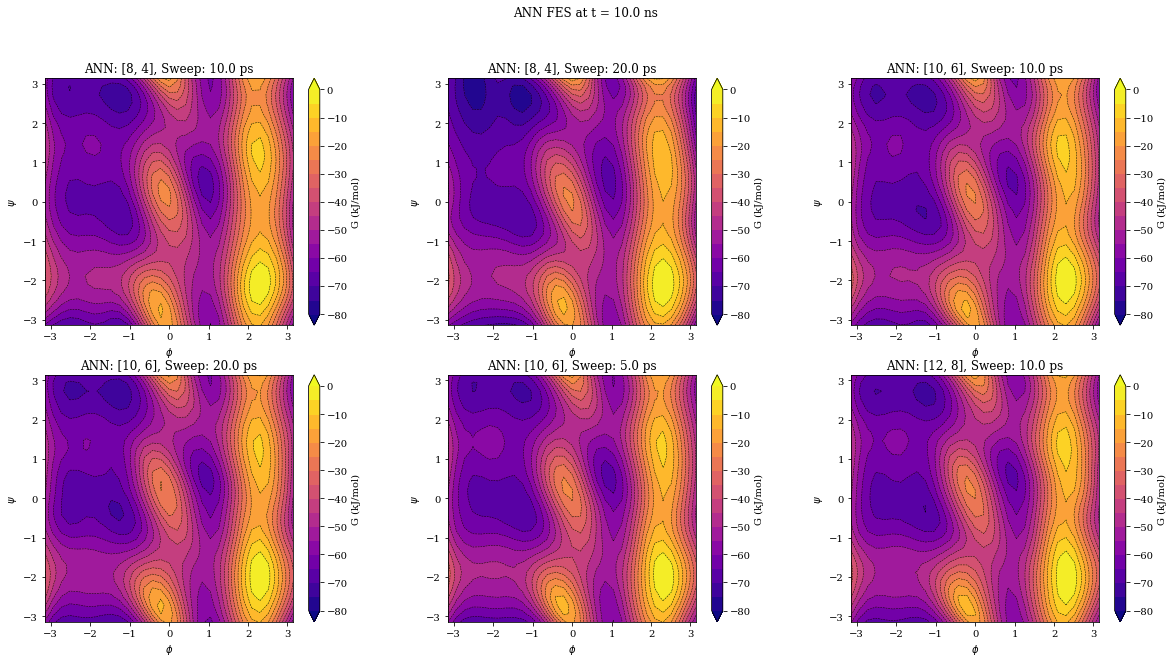

In [22]:
m = len(data)
v = np.arange(-80, 5, 5) # Contours to plot.
rmse = [] # Collect RMSE between reference FES.
for t in times:
    fig = plt.figure(figsize=(20, 10))
    fig.suptitle("ANN FES at t = {} ns".format(t/1000.))
    i = 0
    
    rmsv = []
    for d in data:
        ax = fig.add_subplot(2, 3, i+1)
        fig.subplots_adjust(wspace=0.3)
        folder, arch, sweep = d
        frame = int(t/(sweep*dt))
        
        # Load data and reshape into grid.
        X = np.loadtxt("{}/ann.dat{}".format(folder, frame))
        xg = np.reshape(X[:,0], (31, 31))
        yg = np.reshape(X[:,1], (31, 31))
        zg = np.reshape(-X[:,3], (31, 31))
        zg = zg - np.max(zg)
        
        # Append RMSE
        rmsv.append(compute_rmse(xg, yg, zg))
        
        # PLot data.
        plt.title("ANN: [{}, {}], Sweep: {} ps".format(arch[0], arch[1], sweep*dt))
        plt.contour(xg, yg, zg, v, linewidths=0.5, colors="k")
        plt.contourf(xg, yg, zg, v, cmap=plt.cm.plasma, extend="both")
        cb = plt.colorbar()
        cb.set_label("G (kJ/mol)")
        plt.xlabel("$\phi$")
        plt.ylabel("$\psi$")
        plt.xlim((-np.pi, np.pi))
        plt.ylim((-np.pi, np.pi))

        i += 1
    
    # Append RMSE vector.
    rmse.append(rmsv)
    # Save figure. 
    plt.savefig("ann_{:.1f}ns.png".format(t/1000.))
    plt.savefig("ann_{:.1f}ns.eps".format(t/1000.))

rmse = np.array(rmse)

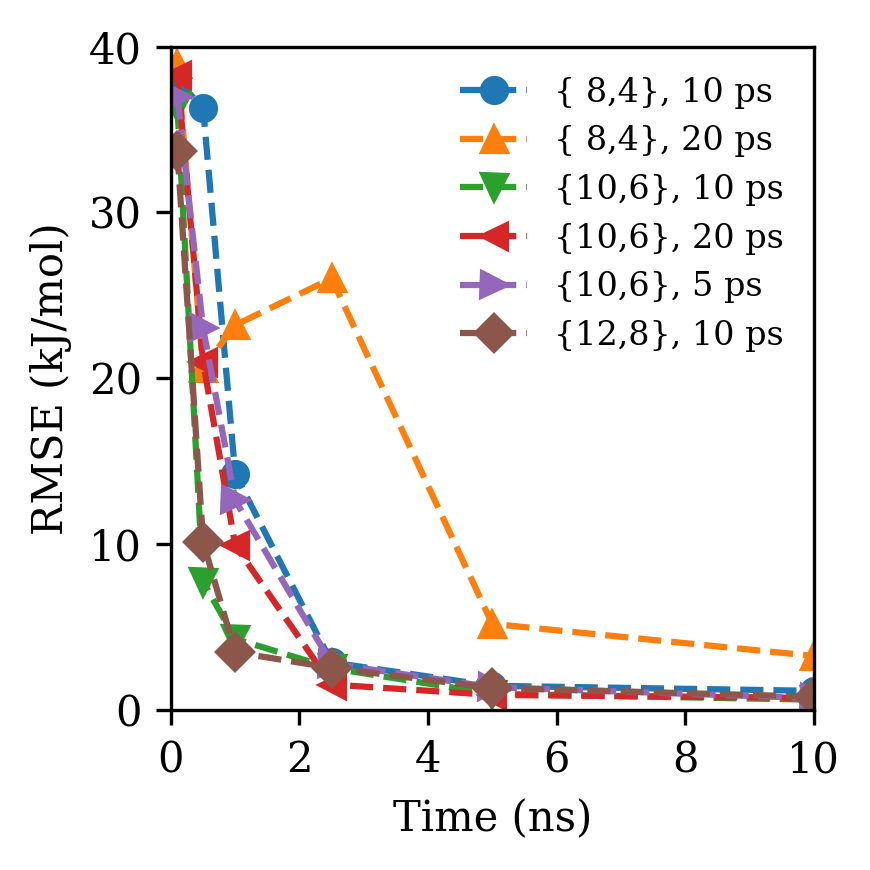

In [23]:
fig = plt.figure(figsize=(3, 3), dpi=300)
markers = ["o", "^", "v", "<", ">", "D"]
labels = []
for i in range(rmse.shape[1]):
    plt.plot(times/1000., rmse[:,i], linestyle="--", marker=markers[i])
    folder, arch, sweep = data[i]
    labels.append("{{{:>2d},{:1d}}}, {:.0f} ps".format(arch[0], arch[1], sweep*dt))

plt.xlim((0, 10))
plt.ylim((0, 40))
plt.xlabel("Time (ns)")
plt.ylabel("RMSE (kJ/mol)")
l = plt.legend(labels, frameon=False, fontsize=8)
plt.tight_layout()
plt.savefig("ann_rmsd.png")
plt.savefig("ann_rmsd.eps")
plt.show()